# **Section 1: Accessing Database**

In [ ]:
!pip install pymysql
import pymysql
import pandas as pd
import numpy as np
from google.colab import data_table
#Connect to MySQL database

cnx = pymysql.connect(user='buspark', password='U@5p1r3!',
                              host='masscourtsplus.org',
                              database='wp_courtdocs')


cursor = cnx.cursor()
# more info here: https://docs.google.com/document/d/1aZKF0X7HjcXUYurD8uQYDpgo9wQdeJH4CMviBJeTYVc/edit#
data_table.enable_dataframe_formatter() #Formats the data table so you can easily see data

# **Section 2: Open ProSer Proper**

In [ ]:
# caseload by attorneys, case type, and count for all cases
query = """
SELECT
    post_title AS attorney,
    case_type,
    COUNT(*) AS count
FROM
    (SELECT
        case_number,
        case_type,
        court,
        court_department,
        attorney_id
    FROM
        (SELECT
            post_id,
            case_number,
            case_type,
            wp_terms.name AS court,
            t1.name AS court_department
        FROM
            cdocs_case_meta_index AS cdocs_meta
        JOIN wp_terms ON wp_terms.term_id = cdocs_meta.court_term_id
        JOIN wp_term_taxonomy ON wp_term_taxonomy.term_id = cdocs_meta.court_term_id
        JOIN wp_terms t1 ON t1.term_id = wp_term_taxonomy.parent) tbl1
    JOIN cdocs_party_assignment_index ON cdocs_party_assignment_index.case_id = tbl1.post_id) tbl2
JOIN
    wp_posts ON wp_posts.id = tbl2.attorney_id
WHERE
    wp_posts.post_type = 'Attorney'
GROUP BY
    post_title,
    case_type
ORDER BY
    count DESC
LIMIT 100;
"""

%time

cursor.execute(query)  # executing query

results = cursor.fetchall()  # fetching result


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [ ]:
open_ps_pp = pd.DataFrame(results).rename({0: 'Attorney',1: 'Case Type',2: 'Count'}, axis = 1)
open_ps_pp

,Attorney,Case Type,Count
0,Pro Se,Housing Court Summary Process,415965
1,Pro Se (PROPER),Housing Court Summary Process,272941
2,"Wilson, Kenneth C",Civil,98090
3,"Wiener, Stephen A.",Small Claims,77737
4,"Wilson, Kenneth C",Small Claims,73394
...,...,...,...
95,"Quijano, Therese E.",Housing Court Summary Process,3937
96,"Gaimari, Francis Anthony",Civil,3894
97,"Howard, Edwin Herbert",Small Claims,3868
98,"Turk, Jeffrey Craig",Summary Process,3844


In [94]:
unique_cases=open_ps_pp['Case Type'].unique()
print("Unique Cases:", unique_cases)
debt_cases = ["Housing Court Civil",  "Housing Court Small Claims", "Small Claims","Civil"]

# Filter the DataFrame with Pro Se
debt_list = open_ps_pp[open_ps_pp['Case Type'].isin(debt_cases)]
print(debt_list)
debt_count = debt_list['Count'].sum()

print("Maximum number of Debt cases:", debt_count)

Unique Cases: ['Housing Court Summary Process' 'Civil' 'Small Claims'
 'Housing Court Civil' 'Supplementary Process'
 'Estates and Administration' 'Housing Court Small Claims'
 'Domestic Relations' 'Paternity Managed' 'Summary Process']
                           Attorney            Case Type  Count
2                Wilson, Kenneth C                 Civil  98090
3               Wiener, Stephen A.          Small Claims  77737
4                Wilson, Kenneth C          Small Claims  73394
5             Kreppel, Gary Howard          Small Claims  73263
6                            Pro Se  Housing Court Civil  69355
..                              ...                  ...    ...
91           Provenzano, Jeanne M.                 Civil   4049
92  Calamita, Grace Marie-Victoria          Small Claims   4011
96        Gaimari, Francis Anthony                 Civil   3894
97           Howard, Edwin Herbert          Small Claims   3868
99                Hughes, Kevin M.          Small Claims   

In [ ]:
ps_pp=open_ps_pp[open_ps_pp['Attorney'].isin(['Pro Se', 'Pro Se (PROPER)'])]
ps_pp


,Attorney,Case Type,Count
0,Pro Se,Housing Court Summary Process,415965
1,Pro Se (PROPER),Housing Court Summary Process,272941
6,Pro Se,Housing Court Civil,69355
10,Pro Se (PROPER),Housing Court Civil,57880
12,Pro Se (PROPER),Estates and Administration,36661
19,Pro Se (PROPER),Housing Court Small Claims,25415
21,Pro Se,Housing Court Small Claims,23581
36,Pro Se,Domestic Relations,11308
44,Pro Se,Paternity Managed,8793
51,Pro Se,Small Claims,7459


In [ ]:
total_count_prose = ps_pp['Count'].sum()

print("Total Open Pro Se and Proper:", total_count_prose)

Total Open Pro Se and Proper: 929358


# **Section 2.5: ProPer, Pro Ser Debt Collectors**

In [92]:
ps_pp

unique_case_types = ps_pp['Case Type'].unique()

print("Unique Case Types:")
for case_type in unique_case_types:
    print(case_type)


Unique Case Types:
Housing Court Summary Process
Housing Court Civil
Estates and Administration
Housing Court Small Claims
Domestic Relations
Paternity Managed
Small Claims


In [91]:

desired_case_types = ["Housing Court Civil",  "Housing Court Small Claims", "Small Claims"]

# Filter the DataFrame with Pro Se
filtered_ps_pp = ps_pp[ps_pp['Case Type'].isin(desired_case_types)]
filtered_ps_pp


,Attorney,Case Type,Count
6,Pro Se,Housing Court Civil,69355
10,Pro Se (PROPER),Housing Court Civil,57880
19,Pro Se (PROPER),Housing Court Small Claims,25415
21,Pro Se,Housing Court Small Claims,23581
51,Pro Se,Small Claims,7459


In [90]:
# Sum up all the counts
debt_prose_count = filtered_ps_pp['Count'].sum()

# Total count of Pro Se Debt Collection Cases
print("Total Count:", debt_prose_count)


Total Count: 183690


# **Analysis of Sections 2**

From section 1 to 2.5 I have found a total of 929358 open and closed cases that are Pro Se. However, finding how many of these 929358 cases that invovled debt collection is a bit of a challenge. I was able to Split the Pro Se cases by
7 case types:

Housing Court Summary Process,

Housing Court Civil,

Estates and Administration,

Housing Court Small Claims,

Domestic Relations,

Paternity Managed,

 Small Claims.

According to Massachusetts law, a debt collection case is always classified as a Civil or a Claims case. Meaning that Housing Court Civil, Housing Court Small Claims, and Small Claims will have all the debt collection cases. From the table above, there is at maximum 183690 Pro Se debt collection cases in Massachusetts

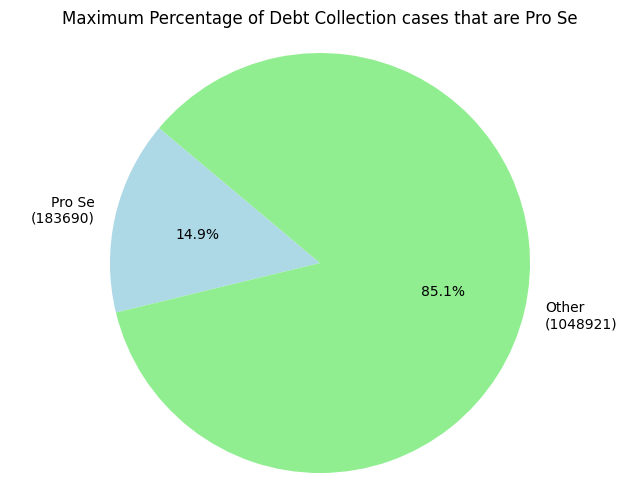

In [96]:
import matplotlib.pyplot as plt
debt_count
debt_prose_count

# Calculate the percentage of debt cases that are Pro Se
percentage_prose = (debt_prose_count / debt_count) * 100
percentage_other = 100 - percentage_prose

# Data for the pie chart
labels = ['Pro Se\n({})'.format(debt_prose_count), 'Other\n({})'.format(debt_count - debt_prose_count)]
sizes = [percentage_prose, percentage_other]



colors = ['lightblue', 'lightgreen']

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Maximum Percentage of Debt Collection cases that are Pro Se')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


1232611

# **Section 3: ProPer, Pro Ser Debt Collectors** (WIP)

In [ ]:
party_ps_pp = pd.DataFrame(results).rename({0: 'Attorney',1: 'Parties',2: 'Count'}, axis = 1)
#ps_pp=party_ps_pp[party_ps_pp['Attorney'].isin(['Pro Se', 'Pro Se (PROPER)'])]

party_ps_pp


,Attorney,Parties,Count,3
0,Pro Se,Housing Court Summary Process,2019,35999
1,Pro Se,Housing Court Summary Process,2018,33929
2,Pro Se,Housing Court Summary Process,2023,33851
3,Pro Se,Housing Court Summary Process,2017,32662
4,Pro Se,Housing Court Summary Process,2013,31384
...,...,...,...,...
95,"Wilson, Kenneth C",Small Claims,2015,6029
96,"Reczek, Erin M.",Civil,2010,6009
97,Pro Se (PROPER),Housing Court Civil,2009,5895
98,Pro Se (PROPER),Housing Court Civil,2010,5845


In [ ]:
party_total_count = party_ps_pp['Count'].sum()

print("Total Open Pro Se and Proper:", party_total_count)

# **Section 4:Total Debt Collectors** (WIP)

In [ ]:
# caseload by attorneys, case type, and count for all cases
query = """
SELECT
    post_title AS attorney,
    case_type,
    SUBSTRING(file_date, 1, 4) AS case_year,
    COUNT(*) AS count
FROM
    (SELECT
        case_number,
        case_type,
        file_date,
        court,
        court_department,
        attorney_id
    FROM
        (SELECT
            post_id,
            case_number,
            case_type,
            file_date,
            wp_terms.name AS court,
            t1.name AS court_department
        FROM
            cdocs_case_meta_index AS cdocs_meta
        JOIN wp_terms ON wp_terms.term_id = cdocs_meta.court_term_id
        JOIN wp_term_taxonomy ON wp_term_taxonomy.term_id = cdocs_meta.court_term_id
        JOIN wp_terms t1 ON t1.term_id = wp_term_taxonomy.parent) tbl1
    JOIN cdocs_party_assignment_index ON cdocs_party_assignment_index.case_id = tbl1.post_id) tbl2
JOIN
    wp_posts ON wp_posts.id = tbl2.attorney_id
WHERE
    wp_posts.post_type = 'Attorney'
GROUP BY
    post_title,
    case_type,
    case_year
ORDER BY
    count DESC
LIMIT 100;

"""

%time

cursor.execute(query)  # executing query

results = cursor.fetchall()  # fetching result


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.29 µs


In [ ]:
all_cases=pd.DataFrame(results).rename({0: 'Attorney',1: 'Case Type',2: 'Year',3: 'Count'}, axis = 1)
# Group the DataFrame by year
grouped_all_case = all_cases.groupby('Year')

sum_counts_by_year = grouped_all_case['Count'].sum()

result_df = pd.DataFrame({
    'Total_Count': sum_counts_by_year
})

result_df.reset_index(inplace=True)

print(result_df)
result_df['Year'] = result_df['Year'].astype(int)

# Filtered DataFrame that includes rows where the Year is 2014 or greater
filtered_result_df = result_df[result_df['Year'] >= 2014]

# Sum of Total
total_sum_2014_or_greater = filtered_result_df['Total_Count'].sum()

print("Sum of Total_count from 2014 or greater:", total_sum_2014_or_greater)

    Year  Total_Count
0   2005        40036
1   2006        62282
2   2007       110830
3   2008       133530
4   2009       121470
5   2010       112114
6   2011        90196
7   2012        88388
8   2013        75487
9   2014        94944
10  2015        83143
11  2016        46622
12  2017        39193
13  2018        40900
14  2019        42410
15  2020        14757
16  2021        23370
17  2022        31002
18  2023        78679
Sum of Total_count from 2014 or greater: 495020


In [ ]:
all=pd.DataFrame(results).rename({0: 'Attorney',1: 'Case Type',2: 'Year',3: 'Count'}, axis = 1)
all_pp=all[all['Attorney'].isin(['Pro Se', 'Pro Se (PROPER)'])]
all_pp
total_count_all_pp = all_pp['Count'].sum()

print("Total Open Pro Se and Proper:", total_count_all_pp)

Total Open Pro Se and Proper: 749830


In [ ]:
debt_case_year = pd.DataFrame(results).rename({0: 'Attorney',1: 'Case Type',2: 'Year',3: 'Count'}, axis = 1)
unique_cases=debt_case_year['Case Type'].unique()
print("Unique Cases:", unique_cases)
debt_cases = ["Housing Court Civil",  "Housing Court Small Claims", "Small Claims","Civil"]

# Filter the DataFrame with Pro Se
debt_list = debt_case_year[debt_case_year['Case Type'].isin(debt_cases)]
debt_list


Unique Cases: ['Housing Court Summary Process' 'Small Claims' 'Civil'
 'Supplementary Process' 'Domestic Relations' 'Paternity Managed'
 'Housing Court Civil']


,Attorney,Case Type,Year,Count
5,"Heinold, Dean A.",Small Claims,2014,31057
23,"Wilson, Kenneth C",Civil,2009,17486
24,"Heinold, Dean A.",Small Claims,2015,17223
25,"Wilson, Kenneth C",Civil,2010,16385
27,"Wiener, Stephen A.",Small Claims,2009,14484
29,"Wilson, Kenneth C",Civil,2011,13998
30,"Wilson, Kenneth C",Small Claims,2013,13885
31,"Wilson, Kenneth C",Civil,2008,13829
33,"Wiener, Stephen A.",Civil,2009,13176
35,"Wiener, Stephen A.",Small Claims,2012,12915


In [ ]:
debt_count = debt_list['Count'].sum()

print("Maximum number of Debt cases:", debt_count)

Maximum number of Debt cases: 568960


In [ ]:
# Group the DataFrame by year
grouped_debt_list = debt_list.groupby('Year')

sum_counts_by_year = grouped_debt_list['Count'].sum()

result_df = pd.DataFrame({
    'Total_Count': sum_counts_by_year
})

result_df.reset_index(inplace=True)

print(result_df)
result_df['Year'] = result_df['Year'].astype(int)

# Filtered DataFrame that includes rows where the Year is 2014 or greater
filtered_result_df = result_df[result_df['Year'] >= 2014]

# Sum of Total
total_sum_2014_or_greater = filtered_result_df['Total_Count'].sum()

print("Sum of Total_count from 2014 or greater:", total_sum_2014_or_greater)
# 1166816 Total in last 10 years


    Year  Total_Count
0   2005         6476
1   2006        28000
2   2007        73591
3   2008        85743
4   2009        73749
5   2010        54669
6   2011        32971
7   2012        36981
8   2013        30874
9   2014        50194
10  2015        39422
11  2016         7497
12  2017         6531
13  2018         6971
14  2019         6411
15  2023        28880
Sum of Total_count from 2014 or greater: 145906
